In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from joblib import dump, load
from tqdm import tqdm
import time
from torch.nn import DataParallel
import os
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Hyperparameters
hidden_size = 128
num_layers = 4
batch_size = 64
n_steps = 30
input_size = 2
output_size = 2

predicting_index = 1 # Close price


In [2]:
%reset -f

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

if device == torch.device("cuda"):
    input_filename = "BTCUSDT4Y1MKline_cleaned_24features_nSteps"+str(n_steps)+".csv"
elif device == torch.device("cpu"):
    os.chdir('/Users/faridsoroush/Documents/GitHub/Trading-Software/Prediction_Model/Transformer/')
    # print("Current working directory: {0}".format(os.getcwd()))
    input_filename = "BTCUSDT4Y1MKline_cleaned_24features_nSteps"+str(n_steps)+".csv"
else:
    print("Device not found")


Device: cpu


In [5]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, y_binary):
        self.X = X
        self.y = y
        self.y_binary = y_binary

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.y_binary[idx]

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 128)
        self.fc2 = nn.Linear(128, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return out[:, 0], torch.sigmoid(out[:, 1])

# Define the model
model = LSTM(input_size, hidden_size, num_layers, output_size)
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = DataParallel(model)
model.to(device)

LSTM(
  (lstm): LSTM(2, 128, num_layers=4, batch_first=True)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [6]:
# weights_path = 'model_parameters_10_2_2_100_128_0.001.pth'
# weights_path = 'LSTM_model_parameters_10_2_128_100_8_0.0001.pth'
weights_path = 'LSTM_model_parameters_30_4_128_10000_64_0.1.pth'

# Load, convert and sort the data
# input_filename = "BTCUSDT4Y1MKline.csv"
input_filename = "BTCUSDT4Y1MKline_cleaned_24features_nSteps30.csv"
df = pd.read_csv(input_filename)
df['Open Time'] = pd.to_datetime(df['Open Time'])
df['Open Time'] = df['Open Time'].values.astype(np.int64) // 10 ** 9
df = df.sort_values('Open Time')
length_df = len(df)
df = df.iloc[length_df-batch_size:length_df]
df=df[['Open Time', 'Close']]
# Use the loaded scaler to transform the new data
#  scaler=MinMaxScaler(feature_range=(0,1))
# scaler=load('scaler.joblib')
# scaled_data = scaler.transform(df.values)
scaled_data = df.values

print(scaled_data.shape)

(64, 2)


In [63]:
# # uses scaling:
# X = []
# y = []
# y_binary = []

# for i in range(n_steps, len(scaled_data)-1):
#     X.append(scaled_data[i - n_steps:i])
#     y.append(scaled_data[i, predicting_index])
# X = np.array(X)
# X = torch.from_numpy(X).float().to(device)
# y = torch.tensor(y, dtype=torch.float32).to(device)

# for i in range(n_steps, len(scaled_data) - 1):
#     y_binary.append(int(scaled_data[i + 1, predicting_index] > scaled_data[i, predicting_index]))
# y_binary = torch.tensor(y_binary, dtype=torch.float32).to(device)


# train_size = int(len(X) * 0)
# val_size = int(len(X) * 0) # additional
# # adjusted indices to create validation set
# X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
# y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]
# y_train_binary, y_val_binary, y_test_binary = y_binary[:train_size], y_binary[train_size:train_size + val_size], y_binary[train_size + val_size:]

# # Convert data to PyTorch tensors and create data loaders
# train_dataset = TimeSeriesDataset(X_train, y_train, y_train_binary)
# val_dataset = TimeSeriesDataset(X_val, y_val, y_val_binary)
# test_dataset = TimeSeriesDataset(X_test, y_test, y_test_binary)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# input_size = X_train.shape[2]

# # Define the model
# model = LSTM(input_size, hidden_size, num_layers, output_size)
# if torch.cuda.device_count() > 1:
#     print("Let's use", torch.cuda.device_count(), "GPUs!")
#     model = DataParallel(model)
# model.to(device)

# model.load_state_dict(torch.load(weights_path, map_location=torch.device('cpu')))

# # switch the model to evaluation mode
# model.eval()

# # initialize arrays to store predictions and actual values
# test_preds = []
# test_actuals = []
# accuracy=0
# # perform the testing
# with torch.no_grad():
#     for i, (batch_X, batch_y_continuous, batch_y_binary) in enumerate(test_loader):
#         batch_y_continuous = batch_y_continuous.float().to(device)
#         batch_y_binary = batch_y_binary.to(device)
#         batch_X = batch_X.to(device)
#         outputs, outputs_binary = model(batch_X.float())
#         accuracy += (outputs_binary.round() == batch_y_binary).float().mean()
#         test_preds.append(outputs.detach().cpu().numpy())
#         test_actuals.append(batch_y_continuous.detach().cpu().numpy())

# # compute the accuracy
# accuracy = accuracy / len(test_loader)
# print(f"Accuracy on Test Data: {accuracy}")

# # convert lists to numpy arrays
# test_preds = np.concatenate(test_preds)
# test_actuals = np.concatenate(test_actuals)

# # compute mean squared error on test data
# mse_test = mean_squared_error(test_actuals, test_preds)
# # print(f"Mean Squared Error on Test Data: {mse_test}")

# # Create dummy arrays
# n_features = df.shape[1] # assuming df is your original DataFrame before scaling
# dummy_preds = np.zeros((len(test_preds), n_features))
# dummy_actuals = np.zeros((len(test_actuals), n_features))

# # Replace the 'Close' price column with your predictions/actuals
# dummy_preds[:, predicting_index] = test_preds
# dummy_actuals[:, predicting_index] = test_actuals

# # Now you can inverse transform
# test_preds_inv = scaler.inverse_transform(dummy_preds)[:, predicting_index]
# test_actuals_inv = scaler.inverse_transform(dummy_actuals)[:, predicting_index]

# # # Compute mean squared error on inverse transformed (original scale) data
# # mse_test_inv = mean_squared_error(test_actuals_inv, test_preds_inv)
# # print(f"Mean Squared Error on Test Data (original scale): {mse_test_inv}")

# # Compute errors on inverse transformed (original scale) data
# errors_inv = test_actuals_inv - test_preds_inv
# # Convert errors to percentage terms
# percentage_errors = np.abs(errors_inv / test_actuals_inv) * 100
# # Compute average of the percentage errors
# average_percentage_error = np.mean(percentage_errors)
# print(f"Average Error on Test Data (percentage terms): {average_percentage_error}%")


# # Plotting actual vs predicted prices
# plt.figure(figsize=(14,6))
# plt.plot(test_actuals_inv, color='blue', label='Actual BTC Price')
# plt.plot(test_preds_inv, color='red', label='Predicted BTC Price')
# plt.title('Bitcoin Price Prediction')
# plt.xlabel('Time')
# plt.ylabel('Price')
# plt.legend()
# plt.grid(True)
# plt.show()

Accuracy on Test Data: 0.49926361441612244


NameError: name 'scaler' is not defined

Accuracy on Test Data: 0.5454545617103577
Mean Squared Error on Test Data: 9057692.0
Average Error on Test Data (percentage terms): 9.450305938720703%


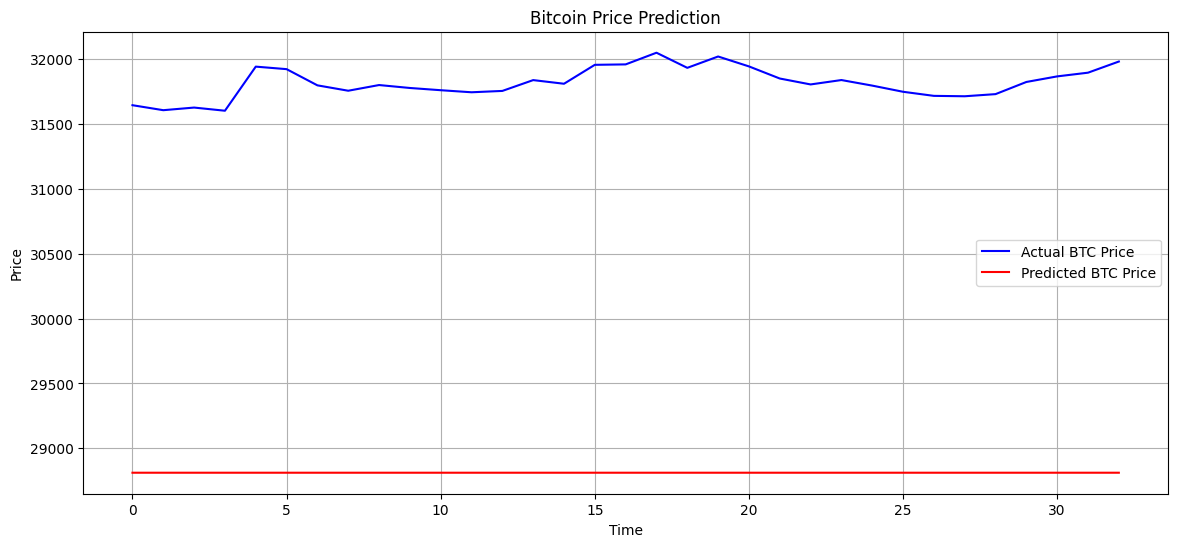

In [17]:
# without scaling
##############################################
X = []
y = []
y_binary = []

for i in range(n_steps, len(scaled_data)-1):
    X.append(scaled_data[i - n_steps:i])
    y.append(scaled_data[i, predicting_index])
X = np.array(X)
X = torch.from_numpy(X).float().to(device)
y = torch.tensor(y, dtype=torch.float32).to(device)

for i in range(n_steps, len(scaled_data) - 1):
    y_binary.append(int(scaled_data[i + 1, predicting_index] > scaled_data[i, predicting_index]))
y_binary = torch.tensor(y_binary, dtype=torch.float32).to(device)


train_size = int(len(X) * 0)
val_size = int(len(X) * 0) # additional
# adjusted indices to create validation set
X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]
y_train_binary, y_val_binary, y_test_binary = y_binary[:train_size], y_binary[train_size:train_size + val_size], y_binary[train_size + val_size:]

# Convert data to PyTorch tensors and create data loaders
train_dataset = TimeSeriesDataset(X_train, y_train, y_train_binary)
val_dataset = TimeSeriesDataset(X_val, y_val, y_val_binary)
test_dataset = TimeSeriesDataset(X_test, y_test, y_test_binary)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

input_size = X_train.shape[2]

# Define the model
model = LSTM(input_size, hidden_size, num_layers, output_size)
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = DataParallel(model)
model.to(device)

model.load_state_dict(torch.load(weights_path, map_location=torch.device('cpu')))
# switch the model to evaluation mode
model.eval()

# initialize arrays to store predictions and actual values
test_preds = []
test_actuals = []
accuracy=0
# perform the testing
with torch.no_grad():
    for i, (batch_X, batch_y_continuous, batch_y_binary) in enumerate(test_loader):
        batch_y_continuous = batch_y_continuous.float().to(device)
        batch_y_binary = batch_y_binary.to(device)
        batch_X = batch_X.to(device)
        outputs, outputs_binary = model(batch_X.float())
        accuracy += (outputs_binary.round() == batch_y_binary).float().mean()
        test_preds.append(outputs.detach().cpu().numpy())
        test_actuals.append(batch_y_continuous.detach().cpu().numpy())

# compute the accuracy
accuracy = accuracy / len(test_loader)
print(f"Accuracy on Test Data: {accuracy}")

# convert lists to numpy arrays
test_preds = np.concatenate(test_preds)
test_actuals = np.concatenate(test_actuals)

# compute mean squared error on test data
mse_test = mean_squared_error(test_actuals, test_preds)
print(f"Mean Squared Error on Test Data: {mse_test}")

# Compute errors on inverse transformed (original scale) data
errors_inv = test_actuals - test_preds
# Convert errors to percentage terms
percentage_errors = np.abs(errors_inv / test_actuals) * 100
# Compute average of the percentage errors
average_percentage_error = np.mean(percentage_errors)
print(f"Average Error on Test Data (percentage terms): {average_percentage_error}%")

# Plotting actual vs predicted prices
plt.figure(figsize=(14,6))
plt.plot(test_actuals, color='blue', label='Actual BTC Price')
plt.plot(test_preds, color='red', label='Predicted BTC Price')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model)} parameters')


The model has 480642 parameters
